In [2]:
import numpy as np
import serial
import time
import h5py
from datetime import datetime
from datetime import date
import cv2
from matplotlib import pyplot as plt

In [3]:

def tactile_reading(path):
    """
    Reads tactile sensor data from an HDF5 file.

    This function opens an HDF5 file at the specified path and extracts 
    tactile sensor data, including frame count, timestamps, pressure readings, 
    and packet IDs. The data is then returned as numpy arrays.

    Parameters:
    path (str): The path to the HDF5 file containing the tactile sensor data.

    Returns:
    tuple:
        pressure (np.ndarray): An array of pressure readings with shape (frame_count,rows,cols). (32x32 by default)
        frame_count (int): The number of frames (or data points) in the file.
        ts (np.ndarray): An array of timestamps with shape (frame_count,).
        packetIDs (np.ndarray): An array of packet IDs with shape (frame_count,9). Represents all packetIDs received during a frame. 
    """
    f = h5py.File(path, 'r')
    fc = f['frame_count'][0]
    ts = np.array(f['ts'][:fc])
    pressure = np.array(f['pressure'][:fc]).astype(np.float32)
    packetIDs = np.array(f['packetNumber'][:fc])
    return pressure, fc, ts, packetIDs

def split_into_segments(pressure, frame_count, time_stamp, packet_loss, N):
    """
    Splits the data into N segments based on timestamps.

    This function divides the pressure, frame count, timestamps, and packet loss data
    into N approximately equal segments based on the total duration of the timestamps. 
    Each segment contains the data within its respective time range.

    Parameters:
    pressure (np.ndarray): An array of pressure readings.
    frame_count (np.ndarray): An array of frame counts.
    time_stamp (np.ndarray): An array of timestamps.
    packet_loss (np.ndarray): An array of packet loss information.
    N (int): The number of segments to split the data into.

    Returns:
    tuple:
        pressure_segments (list of np.ndarray): A list of pressure reading segments.
        frame_count_segments (list of np.ndarray): A list of frame count segments.
        time_stamp_segments (list of np.ndarray): A list of timestamp segments.
        packet_loss_segments (list of np.ndarray): A list of packet loss segments.
    """
    # Calculate the total duration
    total_duration = time_stamp[-1] - time_stamp[0]
    
    # Calculate the approximate duration for each segment
    segment_duration = total_duration / N
    
    # Initialize lists to hold the segments
    pressure_segments = []
    frame_count_segments = []
    time_stamp_segments = []
    packet_loss_segments = []

    # Initialize the start index for the first segment
    start_index = 0

    for i in range(N):
        # Determine the end time for the current segment
        end_time = time_stamp[0] + (i + 1) * segment_duration
        
        # Find the index where the time_stamp exceeds the end_time
        end_index = np.searchsorted(time_stamp, end_time, side='right')
        
        # Slice the arrays to form the current segment
        pressure_segments.append(pressure[start_index:end_index])
        frame_count_segments.append(frame_count[start_index:end_index])
        time_stamp_segments.append(time_stamp[start_index:end_index])
        packet_loss_segments.append(packet_loss[start_index:end_index])
        
        # Update the start index for the next segment
        start_index = end_index

    return pressure_segments, frame_count_segments, time_stamp_segments, packet_loss_segments

#Return throughput in frames per second and Mbps
def getThroughput(ts, fc):
    """
    Calculate throughput in frames per second (FPS) and megabits per second (Mbps).

    This function computes the throughput of data transmission based on the 
    timestamps and frame counts. The throughput is calculated as the number of frames
    transmitted per second and the data rate in megabits per second.

    Parameters:
    ts (np.ndarray): An array of timestamps.
    fc (np.ndarray): An array of frame counts.

    Returns:
    tuple:
        fps (float): Throughput in frames per second.
        mbps (float): Throughput in megabits per second.
    """
    return (fc[-1]-fc[0])/(ts[-1]-ts[0]), ((fc[-1]-fc[0])*66*32)/((ts[-1]-ts[0])*125000)

def getPacketLoss(packetLoss, fc):
    """
    Calculate packet loss as a fraction of expected packets.

    This function calculates the packet loss ratio based on the provided packet loss
    information and frame counts. It flattens the nested packet loss list, filters out
    zeros, and computes the expected and received packet counts to determine the packet 
    loss ratio.

    Parameters:
    packetLoss (list of lists): A nested list containing packet loss information.
    fc (np.ndarray): An array of frame counts.

    Returns:
    float: The packet loss ratio as a fraction of expected packets.
    """
    flattened = np.array([item for sublist in packetLoss for item in sublist])
    flattened = flattened[flattened!=0]
    expectedPackets = np.max(flattened)-np.min(flattened)
    packetsReceived = np.min((expectedPackets, len(flattened)))
    packetsLost = expectedPackets-packetsReceived
    return packetsLost/(expectedPackets)

In [4]:
bleSenders = [['ble_1_sender_1.hdf5'],['ble_2_sender_1.hdf5','ble_2_sender_2.hdf5'],['ble_3_sender_1.hdf5','ble_3_sender_2.hdf5','ble_3_sender_3.hdf5'],
              ['ble_4_sender_1.hdf5','ble_4_sender_2.hdf5','ble_4_sender_3.hdf5','ble_4_sender_4.hdf5'],
              ['ble_5_sender_1.hdf5','ble_5_sender_2.hdf5','ble_5_sender_3.hdf5','ble_5_sender_4.hdf5','ble_5_sender_5.hdf5']]
wifiSenders = [['wifi_1_sender.hdf5'],['wifi_2_sender_1.hdf5','wifi_2_sender_2.hdf5'],['wifi_3_sender_1.hdf5','wifi_3_sender_2.hdf5','wifi_3_sender_3.hdf5'],
               ['wifi_4_sender_1.hdf5','wifi_4_sender_2.hdf5','wifi_4_sender_3.hdf5','wifi_4_sender_4.hdf5'],['wifi_5_sender_1.hdf5','wifi_5_sender_2.hdf5','wifi_5_sender_3.hdf5','wifi_5_sender_4.hdf5','wifi_5_sender_5.hdf5']]
espNowsenders = [['esp_1_sender.hdf5'],['esp_2_sender_1.hdf5','esp_2_sender_2.hdf5'],['esp_3_sender_1.hdf5','esp_3_sender_2.hdf5','esp_3_sender_3.hdf5'],
                 ['esp_4_sender_1.hdf5','esp_4_sender_2.hdf5','esp_4_sender_3.hdf5','esp_4_sender_4.hdf5'],
                 ['esp_5_sender_1.hdf5','esp_5_sender_2.hdf5','esp_5_sender_3.hdf5','esp_5_sender_3.hdf5','esp_5_sender_4.hdf5','esp_5_sender_5.hdf5']]

#Protocol: (mean, std)
throughputDict = {
}
packetLossDict = {
}

AllSenders = [wifiSenders,bleSenders,espNowsenders]
keys = ['WiFi','BLE','Esp']
for i in range(3):
    totalSendExps = len(AllSenders[i])
    finalThroughputMeans = np.zeros(totalSendExps) #Means (per sender) for WiFi, BLE, ESP across experiments
    finalThroughputStds = np.zeros(totalSendExps) #Stds (per sender) for  WiFi, BLE, ESP across experiments
    finalPacketMeans = np.zeros(totalSendExps) 
    finalPacketStds = np.zeros(totalSendExps)
    for j in range(totalSendExps):
        experiment = AllSenders[i][j]
        numSenders = len(experiment)
        numTrials = 5
        totalthroughput = np.zeros((1,numTrials)) #Represents total throughput for all senders (ie N=3) for numTrials experiments (5) 
        totalpacketloss = np.zeros((1,numTrials))
        for k in range(numSenders):
            file=experiment[k]
            pressure, fc, ts, packetLoss = tactile_reading(file)
            #Split data into 5 experiments in order to calculate mean and std
            pressureSplit, fcSplit, tsSplit, packetLossSplit = split_into_segments(pressure,range(fc),ts,packetLoss,numTrials)
            packetLosses = np.array([getPacketLoss(packetLossSplit[i],fcSplit[i]) for i in range(numTrials)])
            framesPerSec = np.array([getThroughput(tsSplit[i],fcSplit[i])[0] for i in range(numTrials)])
            totalthroughput+=framesPerSec
            totalpacketloss+=packetLosses
        throughputPerSender = totalthroughput/numSenders #Represents throughput per sender for numTrials experiments
        packetLossPerSender = totalpacketloss/numSenders #Repressents packet loss per sender for numTrials experiments
        finalThroughputMeans[j]=np.mean(throughputPerSender) #Mean across experiments
        finalThroughputStds[j] = np.std(throughputPerSender)
        finalPacketMeans[j] = np.mean(packetLossPerSender)
        finalPacketStds[j] = np.std(packetLossPerSender)
    throughputDict[keys[i]] = (finalThroughputMeans, finalThroughputStds)
    packetLossDict[keys[i]] = (finalPacketMeans, finalPacketStds)

[56.01791554 58.10141741 61.46552511 55.34824361 63.26706684]
[41.35452562 40.55250779 40.98627848 43.93619839 37.09915864]
[51.69468954 52.27942583 50.45181538 51.07076748 44.97858585]
[50.50338338 51.52624412 50.18921713 44.60668088 40.25395765]
[55.61604834 55.89378687 53.03514104 48.43194939 44.31737646]
[50.29831937 52.55717255 49.69420701 44.3904637  40.52060677]
[30.03793473 41.3704522  40.07149414 40.70014594 39.76966988]
[50.73956374 51.54624927 50.5242331  47.58829573 45.38400767]
[24.77569583 25.8092227  20.6049844  18.27183919 18.16242351]
[27.8852816  18.75830371 20.17594873 16.79179145 21.45213717]
[41.01827526 49.46879747 49.74874049 51.66495137 47.86012114]
[22.4681031  25.27755819 19.93909782 20.12209207 27.43350908]
[38.81533102 48.93885971 49.62808572 51.90220866 48.18837068]
[35.83763922 37.74778285 34.29606277 34.69335519 38.00255521]
[24.99069146 34.1951626  35.8719297  35.74252821 33.41881667]
[8.53035774 8.47625466 8.47585911 8.4499828  8.45845227]
[8.54099371 8

In [23]:
print(packetLossDict)
print(throughputDict)

{'WiFi': (array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.])), 'BLE': (array([0.00500509, 0.45125358, 0.63658405, 0.71499879, 0.76916517]), array([0.00224222, 0.00240804, 0.00656747, 0.0024577 , 0.00043812])), 'Esp': (array([0.68712757]), array([0.00083092]))}
{'WiFi': (array([58.8400337 , 45.4403953 , 48.78897031, 32.52098374, 37.49082503]), array([3.07227377, 2.2730877 , 4.37592542, 1.32882949, 2.46996307])), 'BLE': (array([8.47818132, 4.77512298, 3.21506573, 2.5155029 , 2.00427393]), array([0.02798526, 0.02292998, 0.02439648, 0.01332028, 0.00721501])), 'Esp': (array([9.17398679]), array([0.0144411]))}
0 42196 42196
4266


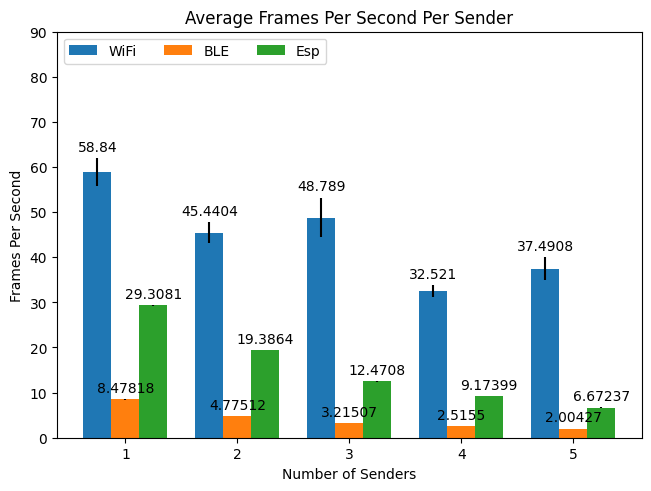

In [7]:
NumSenders = ("1","2","3","4","5")
#Avg and Std
x = np.arange(len(NumSenders))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for protcol, measurement in throughputDict.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement[0], width, label=protcol, yerr=measurement[1])
    ax.bar_label(rects, padding=3)
    multiplier += 1
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Frames Per Second')
ax.set_title('Average Frames Per Second Per Sender')
ax.set_xticks(x + width, NumSenders)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 90)
ax.set_xlabel("Number of Senders")
plt.show()

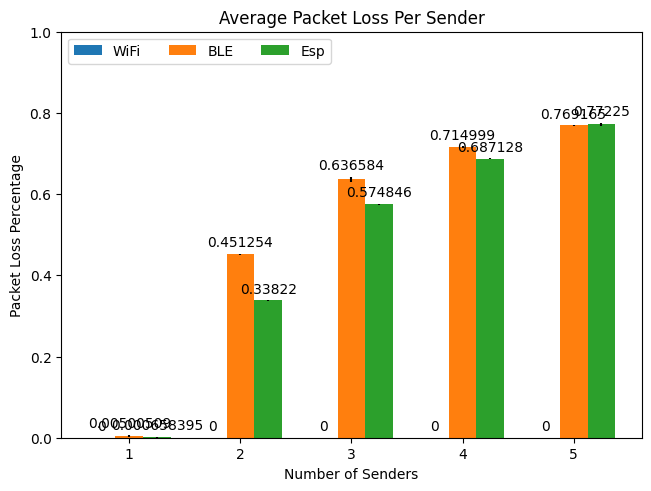

In [8]:
NumSenders = ("1", "2","3","4","5")
#Avg and Std
x = np.arange(len(NumSenders))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for protcol, measurement in packetLossDict.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement[0], width, label=protcol, yerr=measurement[1])
    ax.bar_label(rects, padding=3)
    multiplier += 1
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Packet Loss Percentage')
ax.set_xlabel('Number of Senders')
ax.set_title('Average Packet Loss Per Sender')
ax.set_xticks(x + width, NumSenders)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 1)
plt.show()